In [1]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm as log_progress

In [20]:
#load and clean data
MODEL_NAME = "Test"
#MODEL_NAME = 'shakespear2.0'
data_file_name = "data.txt"
SEQUENCE_LENGTH = 1 #how many items are fed into the ai per sequence

raw = open("data/" + data_file_name, "r", encoding='utf-8')

lines = []
print("Loading data...")
for line in log_progress(raw):
    if str(line) != '\n':
        lines.append(str(line).lower())

print("Tokenizing...")
#putting the entirety of the input data into one string
text = ""
for line in log_progress(lines):
    text += line
#tokenizer = RegexpTokenizer(r'[a-zA-Z]')
tokenizer = RegexpTokenizer(r'\w+')
tokenized = tokenizer.tokenize(text)

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : words.index(x) if x in words else len(words) #convert each word into a number. -1 means that the item isn't in the vocabulary

print("Finding every unique word...")
for word in log_progress(tokenized):
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
print("Compiling dataset...")
counter = 0
for i in log_progress(range(int(len(tokenized)/SEQUENCE_LENGTH))):
    temp = []
    for j in range(0, SEQUENCE_LENGTH):
        if counter + j >= len(tokenized):
            while len(temp) < SEQUENCE_LENGTH:
                temp.append(0)
            break
        else:
            temp.append(find(tokenized[counter+j]))
    
    counter += SEQUENCE_LENGTH - 1
    x.append(temp)
    
    if counter+SEQUENCE_LENGTH < len(tokenized):
        y.append(find(tokenized[counter+SEQUENCE_LENGTH]))
    else:
        y.append(find(tokenized[0]))

x = np.asarray(x, np.int32)
y = np.asarray(y, np.int32)

x = np.reshape(x, (x.shape[0], SEQUENCE_LENGTH, 1))
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words)

Loading data...


0it [00:00, ?it/s]

Tokenizing...


  0%|          | 0/2309 [00:00<?, ?it/s]

Finding every unique word...


  0%|          | 0/18314 [00:00<?, ?it/s]

Compiling dataset...


  0%|          | 0/18314 [00:00<?, ?it/s]

(18314, 1, 1)
(18314, 2)


In [24]:
#create and compile model
model = Sequential()

model.add(Embedding(vocab_size+1, 64, input_length=SEQUENCE_LENGTH)) #embedding: size of vocabulary, dimension of each value
model.add(LSTM(128, dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 64)             205056    
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 304,130
Trainable params: 304,130
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
86/86 [==============================] - 1s 13ms/step - loss: 1.1649e-06 - accuracy: 1.0000 - val_loss: 7.1526e-07 - val_accuracy: 1.0000
Epoch 2/20
86/86 [==============================] - 1s 8ms/step - loss: 1.0971e-06 - accuracy: 1.0000 - val_loss: 7.1526e-07 - val_accuracy: 1.0000
Epoch 3/20
86/86 [==============================] - 1s 7ms/step - loss: 1.0410e-06 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 4/20
86/86 [==============================] - 1s 8ms/step - loss: 9.6341e-07 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 5/20
86/86 [==============================] - 1s 8ms/step - loss: 9.2644e-07 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 6/20
86/86 [==============================] - 1s 7ms/step - loss: 8.9638e-07 - accuracy: 1.0000 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/20
86/86 [==============================] - 1s 7ms/step - loss: 8.5120e-07 - accuracy: 1.0000 - val_los

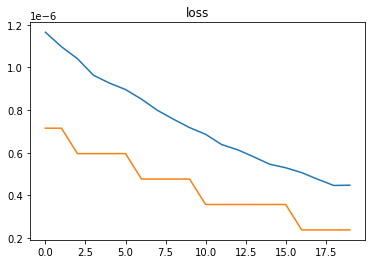

In [33]:
#train model
hist = model.fit(x, y, epochs=20, verbose=1, batch_size=128, shuffle=True, validation_split=0.4)
model.reset_states()
model.save(MODEL_NAME + ".h5")

plt.title("loss")
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

In [44]:
#test model
sample_length = 20
model = load_model("Test.h5")

#get input sentence and process
sentence = input("Enter first " + str(SEQUENCE_LENGTH) + " words...").lower()
tokenizer = RegexpTokenizer(r'\w+')
root = tokenizer.tokenize(sentence)
root = [find(root[i]) for i in range(len(root))]

output = sentence + " "

for i in log_progress(range(sample_length)):
    tmp = np.array(root)
    tmp = np.reshape(tmp, (1, SEQUENCE_LENGTH, 1))
    pred = model.predict(tmp, verbose=0)
    next_word = pred.argmax()
    #next_word = np.random.choice(len(pred[0]), p=pred[0])
    output += words[next_word] + " "
    root.pop(0)
    root.append(next_word) #setting the next word

print(output)

Enter first 1 words...from


  0%|          | 0/20 [00:00<?, ?it/s]

from from from from from from from from from from from from from from from from from from from from from 
